<a href="https://colab.research.google.com/github/PuroshotamSingh/Face-Emotion-Recognition/blob/main/Face_emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction (Training a Face Emotion Detector Sysytem)**

**In our project we have to detect the real time emotions of students so that teachers can understand if students are able to grasp the topic according to students expressions or emotions.**

**So in our project , we first train the model on specific dataset through Convolutional Neural Network(CNN) , then with the help of opencv we capture the real time image , then apply our trained model on that image to detect the emotion of the person .
We made the frontend with the help of streamlit and deployed the entire model on Azure cloud.**

**A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.**

# **Data**

**The dataset consists of 2 folders - training and test.**

**All the images of dataset are grayscale images of size 48,48
Both these folders consist of 7 folders each- angry, disguist, fear, happy,neutral, sad, suprise.**

**All these 7 folders contain images of peoples faces with respective emotion.**

# **Importing relevent libraries**

In [23]:
# Importing libraries

import os
import cv2
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

# **Loading dataset And EDA**

**Let us do some analysis on the dataset we have. We have around 35887 images among which 28709 belong to train set and 7178 belong to test set having 7 classes each. The classes are Angry, Disgust, Fear, Happy, Neutral, Sad and Surprise. The dataset can be downloaded from https://www.kaggle.com/msambare/fer2013.**

In [3]:
# Reading zip file

from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Copy of archive.zip'

In [4]:
# Extracting zip file

with ZipFile(file_name, 'r') as zip:
  zip.extractall(path='fer13')
  print('Done')

Done


In [5]:
# Reading input path

INPUT_PATH = "/content/fer13"

In [6]:
# specifying the image size we want to input in model

picture_size=48

In [7]:
# lsit of all classes

classes = ['angry','disgust','fear','happy','neutral','sad','surprise']

angry
disgust
fear
happy
neutral
sad
surprise


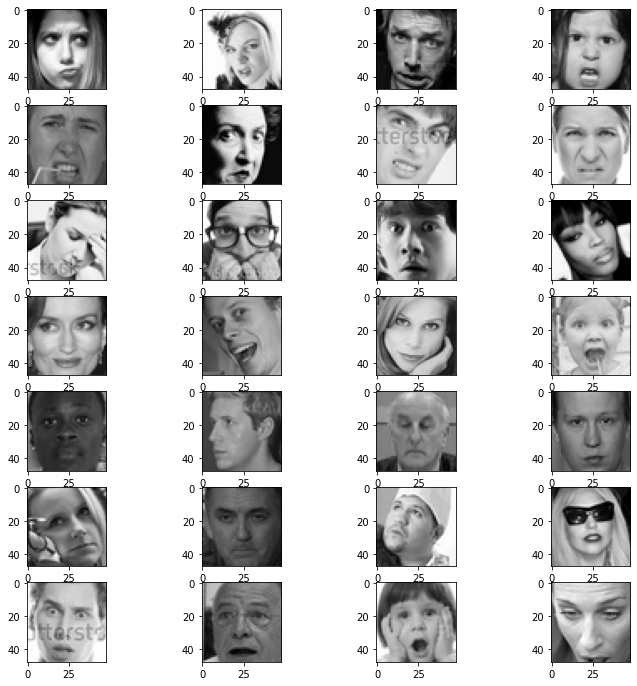

(48, 48, 3)


In [8]:
# viewing some of the images from each category

plt.figure(figsize= (12,12))
i=1
for category in classes:
  for j in range(1,5):
    plt.subplot(7,4,i)
    img = load_img(INPUT_PATH + "/" +"train/"+category+"/"+
                  os.listdir(INPUT_PATH + "/" + "train/" + category)[j], target_size=(picture_size, picture_size))
    plt.imshow(img)
    i+=1
  print(category) 
plt.show()
x=img_to_array(img)
print(x.shape)

In [9]:
# finding the count of images in each category

category=[]
examples=[]
for i in classes:
    dir=INPUT_PATH + "/"+ 'train/'+i
    onlyfiles = next(os.walk(dir))[2] #dir is your directory path as string
    category.append(i)
    examples.append(len(onlyfiles))

In [10]:
# creating a dataframe for the count of images

example_count_df=pd.DataFrame(category,columns=['Category'],index=[1,2,3,4,5,6,7])
example_count_df['No. of images']=examples
example_count_df

,Category,No. of images
1,angry,3995
2,disgust,436
3,fear,4097
4,happy,7215
5,neutral,4965
6,sad,4830
7,surprise,3171


Text(0.5, 1.0, 'Count of images in each category')

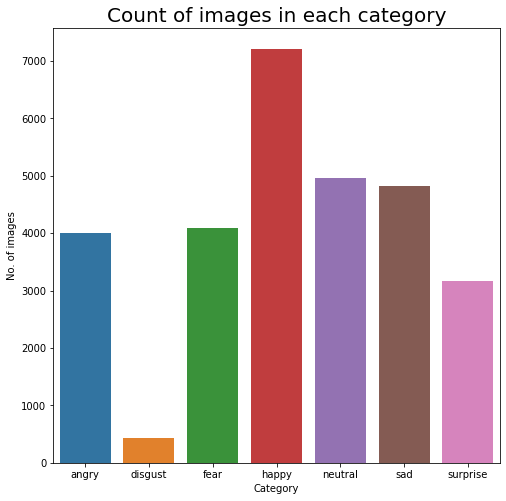

In [11]:
# visualizing

plt.figure(figsize=(8,8))
sns.barplot(x=example_count_df['Category'],y=example_count_df['No. of images'])
plt.title('Count of images in each category',fontsize=20)

**The above graph shows that 'Happy' images count is in majority and 'Disgust' images count is in minority. This tells us that we might not be able to recognize ‘disgust’ faces with effectively with this data set.**

# **Data preprocessing**

**We just cant pass a image into the model, it must be converted into some form of tensor. Therefore, using ImageDataGenerator function of keras library helps to generate batches of tensor image data with real-time data augmentation.**

In [12]:
# defining the train and test set 
batch_size  = 128

datagen_train  = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(INPUT_PATH + "/"+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(INPUT_PATH + "/"+"test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Building a CNN model**

In [13]:
# defining a CNN model
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### **Here we will define a checkpoint for the model so that it continously monitors the model and checks for the validation accuracy and saves only the best model.**

### **We also define the epochs which is basically model going through the entire dataset once.**

In [20]:
# defining a callback that will save the best model

checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=3,
                          verbose=1,

                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              )

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 10

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# **Training the CNN model**

**Here we will train our compiled model. We pass the training set for training and test set for validation. The model keeps on training and validating in a each run and saves that model which gives the highest validation accuracy.**

In [21]:
# Fitting and training the model

history = model.fit_generator(generator=train_set,
                              steps_per_epoch=train_set.n//train_set.batch_size,
                              epochs=epochs,
                              validation_data = test_set,
                              validation_steps = test_set.n//test_set.batch_size,
                              callbacks=callbacks_list,
                              use_multiprocessing=True
                                )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
224/224 [==============================] - 1398s 6s/step - loss: 1.2236 - accuracy: 0.5320 - val_loss: 1.4750 - val_accuracy: 0.4118

Epoch 00001: val_accuracy improved from -inf to 0.41183, saving model to model.h5
Epoch 2/10
224/224 [==============================] - 1425s 6s/step - loss: 1.1836 - accuracy: 0.5484 - val_loss: 1.1769 - val_accuracy: 0.5492

Epoch 00002: val_accuracy improved from 0.41183 to 0.54925, saving model to model.h5
Epoch 3/10
224/224 [==============================] - 1398s 6s/step - loss: 1.1507 - accuracy: 0.5612 - val_loss: 1.1825 - val_accuracy: 0.5382

Epoch 00003: val_accuracy did not improve from 0.54925
Epoch 4/10
224/224 [==============================] - 1411s 6s/step - loss: 1.1213 - accuracy: 0.5745 - val_loss: 1.2001 - val_accuracy: 0.5427

Epoch 00004: val_accuracy did not improve from 0.54925
Epoch 5/10
224/224 [==============================] - 1409s 6s/step - loss: 1.1054 - accuracy: 0.5806 - val_loss: 1.2102 - val_accuracy: 0.5381

**Our model has been trained. It took almost 6 hours to train this simple model. If we would be using other deep CNN models like VGG, Resnet, mobilenet etc, imagine how much time it would take to train it!.**

# **Model Evaluation**

In [24]:
# loading the saved model

trained_model=load_model('/content/model.h5')

In [25]:
# evaluating the train set

trained_model.evaluate(train_set)

225/225 [==============================] - 306s 1s/step - loss: 1.1804 - accuracy: 0.5477


[1.1804389953613281, 0.5476679801940918]

In [26]:
# evaluating the test set

trained_model.evaluate(test_set)

57/57 [==============================] - 74s 1s/step - loss: 1.1757 - accuracy: 0.5499


[1.1757112741470337, 0.5498746037483215]

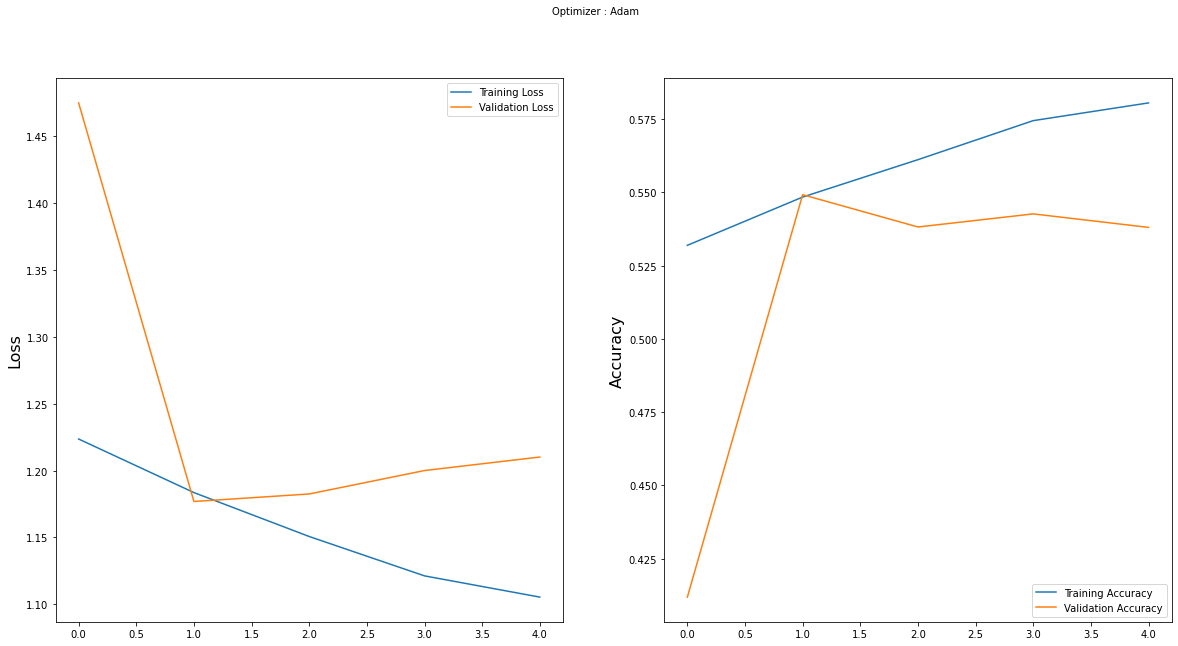

In [27]:
# plotting the Loss for training and validation set
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# plotting the Accuracy for training and validation set
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **Conclusion**

**Thats it! Our model has been trained.**

**At the end we got an accuracy of around 54% on the train set and 55% on the test set. Considering less amount of data to train and less computation power, this can be considered a worth model.**

**As always the performance of the model is not limited to these numbers. It can improve if we use more deeper networks, transfer learning, tunings etc, but at the cost of more time and more computation power.**